# US Stock Market EDA

**Описание задачи:**

У нас в распоряжении набор данных с фондового рынка США, нам предстоит предсказать стоимость активов на следующую неделю.

##### **Содержание:**
- [Pipeline](#1)
- [Графики результатов](#2)

**Описание данных:** <a id='1'></a>

В данном проекте буду использовать набор данных с [Kaggle](https://www.kaggle.com/datasets/saketk511/2019-2024-us-stock-market-data/data), который  предоставляет всестороннее представление о фондовом рынке США, включая различные сырьевые товары, криптовалюты и основные акции. Данные обновляются ежедневно и охватывают период примерно в один месяц. На момент анализа данные содержат финансовые данные  за период с 1 января 2020 года по 26 января 2024 года.

**Набор данных включает следующие столбцы (39):**

- Date
- Natural Gas Price **end** Natural Gas Vol. - цена и объемы природного газа
- Crude Oil Price **end** Crude Oil Vol. - цена и объемы на сырую нефть
- Copper Price **end** Copper Vol. - цена и объемы на медь
- Bitcoin Price **end** Bitcoin Vol. - цена и объемы биткоина
- Platinum Price **end** Platinum Vol. - цена и объемы платины
- Ethereum Price **end** Ethereum Vol. - цена и объемы Эфириума
- S&P 500 Price - цена на S&P 500
- Nasdaq 100 Price **end** Nasdaq 100 Vol. - цена и объемы Nasdaq 100
- Apple Price **end** Apple Vol. - цена и объемы Apple
- Tesla Price **end** Tesla Vol. - цена и объемы Tesla
- Microsoft Price **end** Microsoft Vol. - цена и объемы Microsoft
- Silver Price **end** Silver Vol. - цена и объемы серебра
- Google Price **end** Google Vol. - цена и объемы Google
- Nvidia Price **end** Nvidia Vol. - цена и объемы Nvidia
- Berkshire Price **end** Berkshire Vol. - цена и объемы Berkshire
- Netflix Price **end** Netflix Vol. - цена и объемы Netflix
- Amazon Price **end** Amazon Vol. - цена и объемы Amazon
- Meta Price **end** Meta Vol. - цена и объемы металла
- Gold Price **end** Gold Vol. - цена и объемы золота
- Bitcoin Price (5 Minute) **end** Bitcoin Vol. (5 Minute) - цена и объемы биткоина (5 минут)

Загрузим библиотеки необходимые для работы с данными и сами данные: 

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import warnings
import time
import lightgbm as lgbm
import catboost as cb
warnings.filterwarnings("ignore")

In [13]:
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import kurtosis
from scipy.signal import find_peaks
from statsmodels.iolib.table import SimpleTable
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from statsmodels. tsa.stattools import adfuller
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, mean_absolute_error

In [14]:
RS = 42
SPLITS = 3
col = ['Bitcoin_Price', 'Ethereum_Price', 'Apple_Price', 'Tesla_Price', 'Google_Price', 'Nvidia_Price', 'Gold_Price']


#### **Данный Pipeline разработан из развёрнутого анализа, который можно посмотреть в файле Stock_Market.ipynb, там содержится исследовательский анализ данных, отбор признаков, обучение и тестирование моделей.**

## Pipeline  <a id='1'></a>

In [15]:
path = 'US Stock Market Dataset.csv'
try:
    stock_market = pd.read_csv(path)
except FileNotFoundError:
    print(f"Запрашиваемый файл {path} не найден")

In [16]:
class DateFormatter(BaseEstimator, TransformerMixin):
    '''В этом блоке определяем класс DateFormatter, который 
    выполняет форматирование даты'''
    def fit(self, stock_market, y=None):
        return self
    
    def transform(self, stock_market):
        stock_market = stock_market.copy()
        for i in range(len(stock_market)):
            if '/' in stock_market.loc[i, 'Date']:
                d, m, y = stock_market.loc[i, 'Date'].split('/')
                stock_market.loc[i, 'Date'] = f"{y}-{m.zfill(2)}-{d.zfill(2)}"
        return stock_market
        
class DateConverter(BaseEstimator, TransformerMixin):
    ''' Класс DateConverter преобразует столбец с датами в формат datetime'''
    def fit(self, stock_market, y=None):
        return self
    
    def transform(self, stock_market):
        stock_market = stock_market.copy()
        for index in range(len(stock_market)):
            try:
                stock_market.loc[index, 'Date'] = pd.to_datetime(stock_market.loc[index, 'Date'], dayfirst=False)
            except:
                print(index, stock_market.loc[index, 'Date'])
        stock_market = stock_market.iloc[::-1]
        return stock_market.set_index('Date').asfreq('d')

class ObjectColumnProcessor(BaseEstimator, TransformerMixin):
    '''Класс ObjectColumnProcessor обрабатывает столбцы типа объект, преобразуя строки в числа'''
    def fit(self, stock_market, y=None):
        return self
    
    def transform(self, stock_market):
        stock_market = stock_market.copy()
        col_object = stock_market.select_dtypes(include=['object']).columns
        for col in col_object:
            stock_market[col] = stock_market[col].apply(lambda x: float(str(x).replace(",", "")))
        return stock_market

class ColumnSelector(BaseEstimator, TransformerMixin):
    ''' Класс ColumnSelector выбирает определенные столбцы для обработки'''
    def fit(self, stock_market, y=None):
        return self
    
    def transform(self, stock_market):
        return stock_market[['Bitcoin_Price', 'Ethereum_Price', 'Apple_Price', 'Tesla_Price', 'Google_Price', 'Nvidia_Price', 'Gold_Price']]

class AdditionalProcessor(BaseEstimator, TransformerMixin):
    ''' Класс AdditionalProcessor выполняет дополнительную обработку данных'''
    def fit(self, stock_market, y=None):
        return self
    
    def transform(self, stock_market):
        stock_market = stock_market.copy()
        stock_market.interpolate(inplace=True)
        stock_market = stock_market.diff(periods=1).dropna()
        return stock_market
        
# Создаем pipeline для последовательной обработки данных
pipeline = Pipeline([
    ('date_format', DateFormatter()),
    ('convert_date', DateConverter()),
    ('process_object_columns', ObjectColumnProcessor()),
    ('select_columns', ColumnSelector()),
    ('additional_processing', AdditionalProcessor())
])
# Обработка данных с использованием pipeline
processed_data = pipeline.fit_transform(stock_market)


In [17]:
processed_data.head()

,Bitcoin_Price,Ethereum_Price,Apple_Price,Tesla_Price,Google_Price,Nvidia_Price,Gold_Price
Date,,,,,,,
2020-01-03,376.100000,7.08,-0.730000,0.85,-0.350000,-0.960000,24.300000
2020-01-04,138.666667,3.27,0.196667,0.19,0.603333,0.083333,5.466667
2020-01-05,138.666667,3.27,0.196667,0.19,0.603333,0.083333,5.466667
2020-01-06,138.666667,3.27,0.196667,0.19,0.603333,0.083333,5.466667
2020-01-07,396.600000,-1.04,-0.350000,1.17,-0.130000,0.710000,5.500000


Фондовый рынок и его активы, такие как биткоин, золото, Google, Apple и Tesla, представляют собой динамичные и сложные инструменты инвестирования. Цены на эти активы постоянно находятся в движении под воздействием различных факторов, их требуется дополнительное и внимательное рассмотрение.

При анализе данных фондового рынка с помощью цикла можно проходить по интересующим активам и прогнозировать изменения их цен. Для этого необходимо использовать соответствующие методы и модели, чтобы получить более точные прогнозы.

В нашем случае, данные были взяты с [Kaggle](https://www.kaggle.com/datasets/saketk511/2019-2024-us-stock-market-data/data) за период с 2019 по 2024 год. После обучения трех различных моделей, включая LGBMRegressor, мы получили результаты, показывающие, что модель LGBMRegressor демонстрирует более хорошие прогностические способности. Поэтому рекомендуется использовать модель LGBMRegressor для дальнейшей работы с взятыми данными на фондовом рынке. 


In [10]:
for i in range (len(col)):

    stock_item = pd.DataFrame(processed_data.iloc[:, i])
    # Выделяем простые временные признаки
    stock_item['quarter'] = stock_item.index.quarter
    stock_item['month'] = stock_item.index.month
    stock_item['week'] = stock_item.index.isocalendar().week.values
    stock_item['dayofweek'] = stock_item.index.dayofweek

    # Скользящее окно (скользящее среднее)
    stock_item['rolling_window'] = stock_item.iloc[:, 0].rolling(7).mean()
    # Скользящее окно для расчета эксцессов
    stock_item['kurtosis'] = stock_item['rolling_window'].rolling(7).apply(lambda x: kurtosis(x))
    # Скользящее окно для расчета пиков
    stock_item['peaks'] = stock_item['rolling_window'].rolling(7).apply(lambda x: len(find_peaks(x)[0]))
    # Расширяющееся окно
    stock_item['expanding_window'] = stock_item['rolling_window'].expanding(3).mean()
    # Пробегаемся циклом

    for j in range(1, 8):    # or 14, 21
        stock_item['lag_' + str(j)] = stock_item.iloc[:, 5].shift(j)

    stock_item.drop('rolling_window', axis=1, inplace=True)

    stock_item.dropna(inplace=True)
    # Разделение данных на обучающий и тестовый наборы
    train, test = train_test_split(stock_item, shuffle=False, test_size=0.2, random_state=RS)

    X_train = train.drop(train.columns[0], axis= 1)
    y_train = train.iloc[:, 0]

    X_test = test.drop(test.columns[0], axis=1)
    y_test = test.iloc[:, 0]

    # Определение моделей и параметров для поиска по сетке
    splits = TimeSeriesSplit(n_splits=SPLITS)

    # CatBoost
    cat = cb.CatBoostRegressor()
    params_grid_cat = {'iterations': [250], 'learning_rate' : [0.1, 0.2], 'max_depth': [2, 4, 6, 10],
                       'random_state':[42],'verbose':[False]}
    cat_grid = GridSearchCV(cat, params_grid_cat, scoring='neg_root_mean_squared_error', cv=splits)

    # LightGBM
    light = lgbm.sklearn.LGBMRegressor(verbose=-1)
    params_grid_light = {'num_leaves': [1, 3, 5, 10, 15], 'num_iterations': [30, 40, 50],
                         'max_depth': [2, 6, 8],'learning_rate':[0.01, 0.1, 0.2]}
    light_grid = GridSearchCV(light, params_grid_light, scoring='neg_root_mean_squared_error', cv=splits, n_jobs=-1)

    # XGBRegressor
    model_xgboost = XGBRegressor(random_state=42)

    params_grid_xgboost = {'n_estimators': [1000, 1200], 'max_depth': [1, 2, 3],
                           'min_child_weight': [0.5, 0.7], 'learning_rate': [0.1, 0.3, 0.5]}

    xgboost_grid = GridSearchCV(model_xgboost, params_grid_xgboost, scoring='neg_root_mean_squared_error', cv=splits)

    print('Расчётный актив:', col[i])
    models = [cat_grid, light_grid, xgboost_grid]
    name_model = ['CatBoostRegressor', 'LGBMRegressor', 'XGBRegressor']
    for model, model_name in zip(models, name_model):
        model.fit(X_train, y_train)
        RMSE = mean_squared_error(y_test, model.predict(X_test))**0.5
        print(f'RMSE на тесте для модели {model_name}: {RMSE}')
    print('\n')

Расчётный актив: Bitcoin_Price
RMSE на тесте для модели CatBoostRegressor: 616.8227898248737
RMSE на тесте для модели LGBMRegressor: 596.1254523300825
RMSE на тесте для модели XGBRegressor: 628.1443678288853


Расчётный актив: Ethereum_Price
RMSE на тесте для модели CatBoostRegressor: 44.85259754949254
RMSE на тесте для модели LGBMRegressor: 43.60684024927512
RMSE на тесте для модели XGBRegressor: 50.41075543689816


Расчётный актив: Apple_Price
RMSE на тесте для модели CatBoostRegressor: 1.844461897044386
RMSE на тесте для модели LGBMRegressor: 1.7214108419280898
RMSE на тесте для модели XGBRegressor: 1.8050695522252462


Расчётный актив: Tesla_Price
RMSE на тесте для модели CatBoostRegressor: 5.397984444132703
RMSE на тесте для модели LGBMRegressor: 5.215221266602026
RMSE на тесте для модели XGBRegressor: 5.324835699351181


Расчётный актив: Google_Price
RMSE на тесте для модели CatBoostRegressor: 1.7407179874120504
RMSE на тесте для модели LGBMRegressor: 1.6966504501009134
RMSE на т

## Графики результатов  <a id='2'></a>

Отрисую на графике результат  по Bitcoin на тестовых данных по моделям CatBoost, LightGBM и XGBRegressor

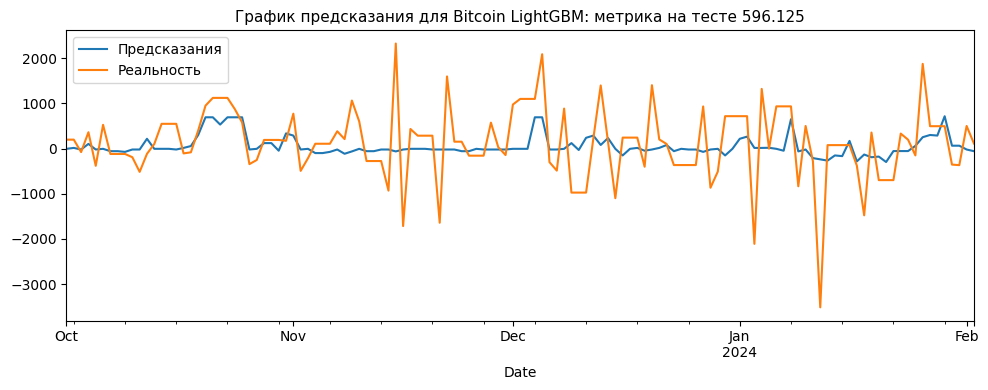

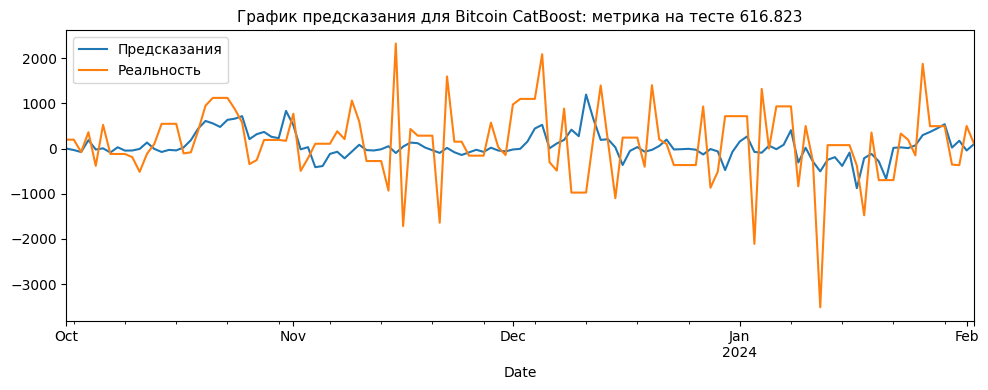

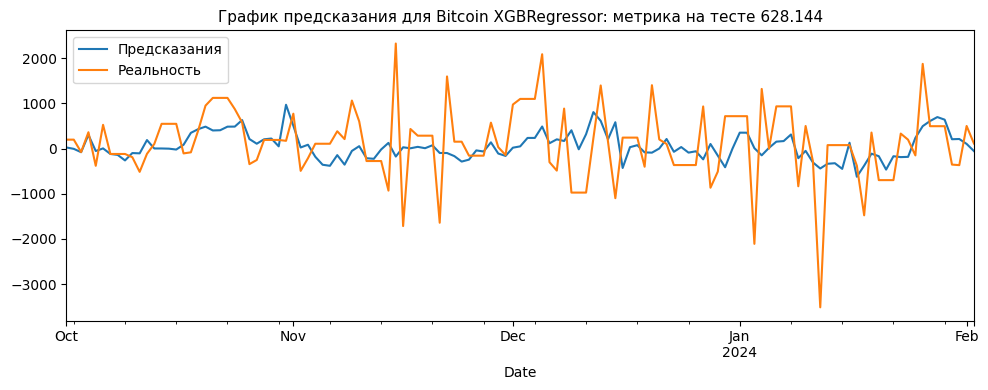

In [19]:
model_lst = [light_grid, cat_grid, xgboost_grid]
model_name = ['LightGBM', 'CatBoost', 'XGBRegressor']
num=0
for model in model_lst:    
    RMSE = pd.Series(model.predict(X_test), index = y_test.index)
    RMSE_metric = mean_squared_error(y_test, model.predict(X_test))**0.5
    plt.figure(figsize=(10, 4))
    plt.title(f'График предсказания для Bitcoin {model_name[num]}: метрика на тесте {round(RMSE_metric, 3)}', fontsize=11)
    RMSE.plot(label = 'Предсказания')
    y_test.plot(label = 'Реальность')
    plt.xlim(['2023-10-01','2024-02-02'])
    plt.legend()
    plt.tight_layout()
    num+=1

В ходе работы я брала данные с фондового рынка, в которых сделала ресемплинг по дням, подготовила к анализу данные, посмотрела на тренд, сезонность. В активах есть недельная сезонность, шум. Данные не стационарны на фондовом рынке по своей природе, поэтому привела ряд к стационарному.

Далее были построены модели для прогнозирования активов рынка с помощью моделей  CatBoost, LightGBM и XGBRegressor. Стоит отметить, что ажно при торговле на рынке отслеживать не MAE, MSE, RMSE, а accuracy по следованию тренду. Если модель прогнозирует, что цена пойдет вниз, а цена на самом деле идет вверх, то перечисленные выше метрики это не покажут, а accuracy покажет.

Целью стояло подготовить модель с меньшей метрикой RMSE. С данной задачью справились  LightGBM, CatBoost, но модель LightGBM показала лучшие результаты на трейне и тесте, возможно и CatBoost был бы более хорош, подобрав более оптимальные параметры, списывать его со счетов не стоит.

По итогу проведённой работы выбрана перспективную модель LightGBM для прогнозирования цен на фондовом рынке в разрезе активов.